# 데이터 전처리의 의미
- 수행하고자 하는 분석에 적합하게 데이터 가공하는 것으로 <br> 결측값 및 이상치를 처리하고, 분석도구에 적합하지 않은 변수는 제거해주며 데이터를 분석에 활용하기 좋도록 품질을 향상시키는 역할 수행
    - 데이터 클린징 : 결측치 처리, 이상치 확인 및 정제
    - 데이터 통합 : 다양한 데이터 파일의 결합 등
    - 데이터 변환 : 스케일링, 요약 등
    - 데이터 축소 : 변수 축소, 라벨링 등
    - 불균형 데이터 처리 : 언더 샘플링, 오버 샘플링
    - 데이터 분할 : train, val, test 데이터 분할

# 이상치 확인 및 정제

## 이상치의 의미
- 결측치, 다른 데이터들과 값의 차이가 큰 데이터
- 측정의 변동성, 실험의 오류, 측정 장비의 오류 등이 이유
- 자료 수집 시, 결측치를 대신하기 위해 넣은 값이 이상치일 수도 있다.
- 자료 수집의 오류로 발생한 이상치는 되도록 제거 하는 것이 모델 성능에 좋다.
    - 관측값과 다른 형식의 이상치
    - 관측값과 형식은 같지만 값이 현저히 차이나는 이상치
    - 자료 수집 오류로 인한 이상치

## 이상치 확인
- 데이터 정의서를 확인하여 기준을 벗어나는 값
- 기준이 없다면 도메인 지식을 가진 사람이 판단
- 수치형의 경우 IQR(inter quantile range) 방식 사용


※ IQR 방식 <BR>
    IQR = Q3 – Q1 (3사분위수에서 1사분위수를 차감)<BR>
    Q3 + 1.5 IQR (최대값) 넘거나, Q1 – 1.5 IQR (최소값) 미만인 수치를 이상치로 판단    


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

wine_load = load_wine()
wine = pd.DataFrame(wine_load.data, columns=wine_load.feature_names)
wine['Class'] = wine_load.target
wine['Class'] = wine['Class'].map({0:'class_0', 1:'class_1', 2:'class_2'})

In [2]:
wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0


In [3]:
wine.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline', 'Class'],
      dtype='object')

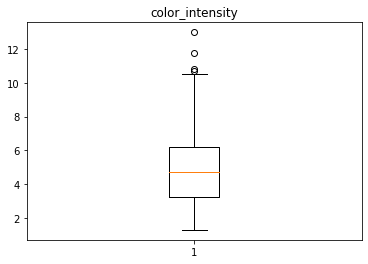

In [4]:
plt.boxplot(wine['color_intensity'], whis=1.5)
plt.title('color_intensity')
plt.show()

- 4개의 이상치가 있음
- 이를 아래와 같이 IQR을 통해 확인 가능
- 하지만 IQR을 활용하는 방법은 너무 많은 데이터를 이상치로 간주 할 가능성이 있다.
- 데이터 유형을 보고 필요에 따라 곱하는 값을 조정하는 것도 방법 (아래의 함수 참고)

In [6]:
import numpy as np

def outliers_iqr(df, col):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    outliers = df[(df[col] < q1 - (iqr*1.5))|(df[col] > q3 + (iqr*1.5))]
    return outliers[[col]]

outliers = outliers_iqr(wine, 'color_intensity')
outliers

,color_intensity
151,10.80
158,13.00
159,11.75
166,10.68


## 이상치 정제
### 이상치 제거
- 데이터 전체 수에 비하여 이상치가 적을 경우 삭제 할 수 있다 <BR>
(단, 삭제시 분석에 사용 가능한 데이터 수가 줄어들기 때문에, 주의한다)

In [7]:
drop_outliers = wine.drop(index=outliers.index)

print('Original : ', wine.shape)
print('Drop outliers : ', drop_outliers.shape)

Original :  (178, 14)
Drop outliers :  (174, 14)


### 이상치 대체
- 이상치를 Null로 만들고, 평균 등의 수치로 대체한다. 

In [8]:
wine.loc[outliers.index, 'color_intensity'] = np.nan
wine['color_intensity']=wine['color_intensity'].fillna(wine['color_intensity'].mean())
wine.loc[outliers.index, 'color_intensity']

151    4.908678
158    4.908678
159    4.908678
166    4.908678
Name: color_intensity, dtype: float64

# 범주형 변수 처리
- 문자열, object, category 형
- 사칙 연산 불가능, 수학적 의미 없음
- 모델 학습에 바로 사용할 수 없어 처리가 필요하다.
- label encoding이나 one hot encoding 등이 사용됨
- one hot encoding(더미 변수)는 범주 별로 컬럼 변수를 만들어, 원본 변수가 해당 컬럼에 포함되면 1로 아니면 0으로 설정
- pd.get_dummies(data, columns=['범주형1', '범주형2'])

In [10]:
# iris 데이터의 Class 변수를 더미 변수화
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target
iris['Class'] = iris['Class'].map({0:'Setosa', 1:'Versicolour', 2:'Virginica'})
iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [11]:
iris_dummy = pd.get_dummies(iris, columns=['Class'])
iris_dummy.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class_Setosa,Class_Versicolour,Class_Virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


# 데이터 분할
- train, test (7:3) 으로 분할 하거나, train, validation, test (6:2:2) 로 분할 하기도
- 데이터가 많은 경우, validation, test의 비율을 줄이기도 한다. 

In [1]:
# iris 데이터를 train:test = 4:1 로 분할 
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target
iris['Class'] = iris['Class'].map({0:'Setosa', 1:'Versicolour', 2:'Virginica'})

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.drop(columns='Class'), iris['Class'], 
                                                    test_size=0.2, random_state=1004)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [3]:
iris['Class'].value_counts()

Setosa         50
Versicolour    50
Virginica      50
Name: Class, dtype: int64

In [4]:
y_train.value_counts()

Versicolour    41
Setosa         40
Virginica      39
Name: Class, dtype: int64

- stratify를 적용하지 않아, 원본 데이터와 분할 한 후의 비율에 차이가 있나
- stratify 옵션을 주게 되면, 옵션으로 받는 데이터의 분포와 동일한 비율의 범주가 되도록 층화 추출을 하게 된다.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.drop(columns='Class'), iris['Class'], 
                                                    test_size=0.2, random_state=1004, stratify=iris['Class'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 4), (30, 4), (120,), (30,))

In [6]:
y_train.value_counts()

Versicolour    40
Virginica      40
Setosa         40
Name: Class, dtype: int64

# 데이터 스케일링
- 변수들 마다 데이터 값의 크기가 차이가 날 경우 알고리즘의 성능에 좋지 않다.

## 데이터 스케일링 방법
- 주의 점은, train와 test 데이터는 같은 scaler를 사용해야 한다.
    1. scaler 선택 및 import
    2. scaler 객체 생성
    3. train 데이터로 fit
    4. train 데이터 transform
    5. test 데이터 transform
    6. 원본 스테일로 변환 scaler_inverse_transform(X_train_scaled)
- 표준화(Standardization) : 평균을 0, 분산을 1인 정규 분포로 만드는 것
- 정규화(Normalization) : 특정 범위(보통 0~1)로 만드는 것 

## Standard Scaler
- 평균을 0, 분산을 1인 정규 분포로 만드는 것
- 최솟값과 최댓값의 크기를 제한하지 않아 이상치에 민감
- 이상치를 미리 확인 및 정제 후 사용하는 것이 좋다.
- 회귀 보다 분류 분석에 유용

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

print('\t\t(min, max), (mean, std)')
print('Train_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_train_sc.min(),
                                                X_train_sc.max(), X_train_sc.mean(), X_train_sc.std()))
print('Test_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_test_sc.min(),
                                                X_test_sc.max(), X_test_sc.mean(), X_test_sc.std()))

		(min, max), (mean, std)
Train_scaled (-2.37, 3.04),(0.00, 1.00)
Test_scaled (-1.76, 2.48),(-0.01, 0.97)


## Min-max Scaler
- 0과 1 사이의 값들로 정규화
- 즉 최솟값이 0, 최댓값이 1이 된다
- 이상치에 매우 민감
- 분류보다 회귀에 유용

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

print('\t\t(min, max), (mean, std)')
print('Train_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_train_sc.min(),
                                                X_train_sc.max(), X_train_sc.mean(), X_train_sc.std()))
print('Test_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_test_sc.min(),
                                                X_test_sc.max(), X_test_sc.mean(), X_test_sc.std()))

		(min, max), (mean, std)
Train_scaled (0.00, 1.00),(0.46, 0.27)
Test_scaled (0.03, 1.06),(0.45, 0.26)


## Max Abs Scaler
- 최대절댓값과 0이 각각 1, 0이 되도록 스케일링
- 모든 값이 -1과 1 사이에 표현
- 데이터가 양수인 경우 Min-Max Scaler와 동일
- 이상치에 매우 민감
- 분류보다 회귀에 유용

In [16]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

print('\t\t(min, max), (mean, std)')
print('Train_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_train_sc.min(),
                                                X_train_sc.max(), X_train_sc.mean(), X_train_sc.std()))
print('Test_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_test_sc.min(),
                                                X_test_sc.max(), X_test_sc.mean(), X_test_sc.std()))

		(min, max), (mean, std)
Train_scaled (0.04, 1.00),(0.62, 0.24)
Test_scaled (0.08, 1.03),(0.62, 0.24)


## Robust Scaler
- 평균과 분산 대신 중앙값과 사분위값을 활용
- 중앙값을 0으로 설정하고 IQR을 사용해 이상치의 영향을 최소화
- quantile_range (기본 값 : 25.0, 75.0) 를 조정하여 이상치 범위를 설정 가능

In [18]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

print('\t\t(min, max), (mean, std)')
print('Train_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_train_sc.min(),
                                                X_train_sc.max(), X_train_sc.mean(), X_train_sc.std()))
print('Test_scaled (%.2f, %.2f),(%.2f, %.2f)'%(X_test_sc.min(),
                                                X_test_sc.max(), X_test_sc.mean(), X_test_sc.std()))

		(min, max), (mean, std)
Train_scaled (-1.90, 2.67),(-0.02, 0.65)
Test_scaled (-1.14, 1.90),(-0.02, 0.62)


## 원본 스케일로 변경
- 스테일링 한 데이터를 원본으로 변경

In [23]:
pd.DataFrame(X_train_sc, columns=X_train.columns).head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.846154,0.190476,0.157143,0.133333
1,-0.153846,-0.380952,0.157143,0.466667
2,-0.076923,0.000000,-0.042857,-0.066667


In [24]:
X_Original = scaler.inverse_transform(X_train_sc)
pd.DataFrame(X_Original, columns=X_train.columns).head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,6.9,3.1,4.9,1.5
1,5.6,2.8,4.9,2.0
2,5.7,3.0,4.2,1.2


In [21]:
X_train.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
52,6.9,3.1,4.9,1.5
121,5.6,2.8,4.9,2.0
95,5.7,3.0,4.2,1.2


# 차원 축소
- '차원의 저주': 변수의 수가 많을 수록 (==차원이 많아질수록), 성능이 저하 되는 현상
- 차원이 늘어감에 따라 데이터 간의 거리가 멀어지는 현상
- 공간의 성김 현상(Sparsity)<br>
<img src="img/sparsity.png" width="500"/>
- 각 변수에서 같은 비율의 데이터를 차원이 증가할 수록 전체 데이터에서 설명 가능한 비율이 줄어 든다.<br>
<img src="img/sparsity2.png" width="500"/>
- 차원이 늘 수록 무조건 차원의 저주가 발생하는 것은 아니다.
- 데이터가 충분히 있다면, 차원이 늘어 새로운 패턴을 발견할 수 있는 가능성을 높일 수도 있다.

## 설명 변수 선택
- 차원을 축소하는 가장 쉬운 방법
- 자료를 잘 설명하는 설명변수 만을 사용한다.
- 다중공선성을 발생시키는 변수를 제거 한다.(서로 상관관계가 높은 변수는 대표성을 띄는 것 하나만 선택)
- 정보가 없는 컬럼, 관련이 없는 컬럼(변수)를 제거 한다 (e.g. ID, 모두 같은 값인 컬럼 등)
    - 장점 : 선택한 설명변수의 해석이 용이, 수행 과정이 간단
    - 단점 : 설명변수 간의 고차원적 상관관계는 고려하기 어렵다

## 주성분 분석 (PCA : Principle Component Analysis)
- 기존의 컬럼을 새롭게 해석, 저차원의 초평면에 투영하는 방법으로 여러 변수간 상관관계를 이용
    - 데이터를 축에 사영하였을 때 분산이 가장 큰 축을 찾아 그 축을 새로운 주성분으로 결정
    - 이 벡터 축에 직각이 되는 벡터를 두 번째 축으로 선택
    - 세 번째 축은 다시 두번째 축과 직각이 되는 벡터를 선택 ...

### 주성분 분석의 과정
#### PCA를 위한 전처리
- 변수 간 스케일의 차이가 영향을 주는 것을 방지 하기 위해 
- 이상치 제거 후 스케일링을 한다

In [2]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['Class'] = load_iris().target
iris['Class'] = iris['Class'].map({0:'Setosa', 1:'Versicolour', 2:'Virginica'})

In [4]:
X = iris.drop('Class', axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame(X_scaled, columns=X.columns).head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444


#### 주성분 추출
- 생성할 주성분의 수를 임의로 정한다
- scikit-learn의 PCA 함수를 이용하여 주성분을 구한다.
- singular_values_ : 전체 데이터에서 해당 모델로 설명할 수 있는 분산의 비율,
    - The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space.
- explained_variance_ratio_ : 전체 데이터에서 각 주성분이 설명할 수 있는 분산 비율a

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pcs = pca.fit_transform(X_scaled)

In [15]:
print(pca.singular_values_)
print(pca.explained_variance_ratio_)

[20.92306556 11.7091661   4.69185798  1.76273239]
[0.72962445 0.22850762 0.03668922 0.00517871]


In [17]:
pd.DataFrame(data=pcs, columns = ['PC1', 'PC2', 'PC3', 'PC4'])

,PC1,PC2,PC3,PC4
0,-2.264703,0.480027,-0.127706,-0.024168
1,-2.080961,-0.674134,-0.234609,-0.103007
2,-2.364229,-0.341908,0.044201,-0.028377
3,-2.299384,-0.597395,0.091290,0.065956
4,-2.389842,0.646835,0.015738,0.035923
...,...,...,...,...
145,1.870503,0.386966,0.256274,-0.389257
146,1.564580,-0.896687,-0.026371,-0.220192
147,1.521170,0.269069,0.180178,-0.119171
148,1.372788,1.011254,0.933395,-0.026129


#### Scree plot으로 사용할 성분의 수 구하기
- Scree plot은 주성분 각각으로 설명할 수 있는 분산의 정도를 점으로 표시하고 이 점을 이은 선
- 주성분의 개수가 증가할 수록 scree plot의 기울기가 감소
- 기울기가 급격하게 감소하는 지점의 직전까지를 주성분으로 선택

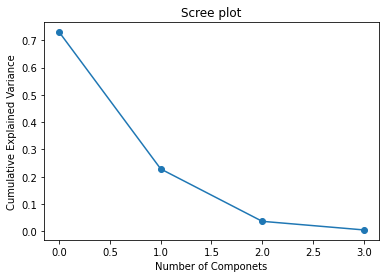

In [19]:
import matplotlib.pyplot as plt

plt.title('Scree plot')
plt.xlabel('Number of Componets')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.show()

#### 새로운 데이터 프레임 확인
- 주성분의 수를 scree plot을 통해 다시 정한다
- pca 객체 생성, fit_transform으로 주성분으로 변환

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
pca_iris = pd.DataFrame(data=pcs, columns = ['PC1', 'PC2'])
pca_iris.head(3)

,PC1,PC2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908


#### 주성분 산포도 확인
- 각 주성분으로 x, y 축 할당
- hue로 원본의 class 입력

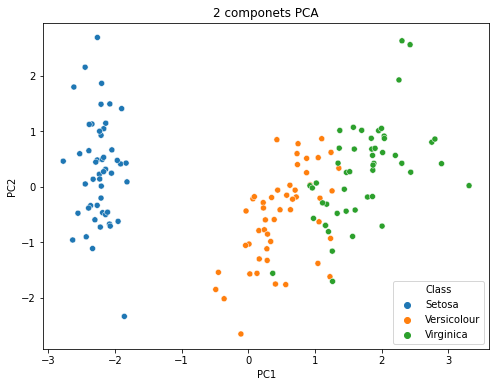

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.title('2 componets PCA')
sns.scatterplot(x='PC1', y='PC2', data=pca_iris, hue=iris.Class)
plt.show()

#### 주성분 산포도 확인
- 각 주성분으로 x, y 축 할당
- hue로 원본의 class 입력

- 정확도가 높은 일반적 모델에서는 소수 데이터를 중요하게 여기지 않는다.
- 데이터의 불균형 상태에서 "소수의 이상 데이터"를 타겟으로 분류해야 되는 상황에서는 어떻게 할까?
  <br> 예시> 암 검진 대상자 중에 암에 걸린 사람을 정확히 가려내어 치료할 수 있나?
    - 무작정 정확도를 높이기보다는 다소 정확도를 포기하더라도 최대한 손실없이 환자를 가려내어 치료를 시작하는 것이 중요
- 이런 문제를 해결하기 위해 제시하는 방법이 소수의 비정상 데이터의 수를 늘리는 오버샘플링과, 상대적으로 많은 정상 데이터에서 일부만 사용하는 언더샘플링 기법을 사용한다.

## 언더샘플링 (Under Sampling)
- 다수의 레이블을 가진 데이터를 샘플링하여 소수의 데이터세트가 가진 레이블의 수 수준으로 감소시키는 기법
    + +) 데이터 불균형으로 인한 문제를 피할 수 있음
    - -) 전체 데이터의 수가 줄어들어 학습성능을 떨어뜨림

In [1]:
# !pip install imbalanced-learn

In [2]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

x, y = make_classification(n_samples=2000, n_features=6, weights=[0.95], flip_y=0) # 95:1의 불균형데이터 가정
print(Counter(y))

Counter({0: 1900, 1: 100})


랜덤언더샘플링 : 다수의 레이블에서 무작위로 데이터를 제거한다. 1900개 였던 0번레이블이 1번레이블 수에 맞춰서 줄어든다

In [3]:
undersample = RandomUnderSampler(sampling_strategy='majority') # 다수의 레이블의 데이터를 샘플링하여 소수의 수와 맞춤
x_under, y_under = undersample.fit_resample(x, y)
print(Counter(y_under))

Counter({0: 100, 1: 100})


In [4]:
undersample = RandomUnderSampler(sampling_strategy=0.5) # 비율 톨해 다수레이블의 갯수 조정 가능
x_under2, y_under2 = undersample.fit_resample(x, y)
print(Counter(y_under2))

Counter({0: 200, 1: 100})


## 오버샘플링 (Over Sampling)
- 소수의 레이블을 지닌 데이터세트를 단순 복제하여 다수의 레이블과 비율을 맞추는 방법
    + +) 불균형문제를 처리하지 않는 것보다는 유효
    + -) 오버피팅의 위험성 있음

In [6]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_over, y_over = oversample.fit_resample(x, y)
print(Counter(y_over))

Counter({0: 1900, 1: 1900})


In [5]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy=0.5) 
x_over, y_over = oversample.fit_resample(x, y)
print(Counter(y_over))

Counter({0: 1900, 1: 950})


SMOTES(Synthentic Minority Over-sampling Technique) : 소수레이블을 지닌 데이터세트의 관측값에 대한 K개의 최근접이웃을 찾고, 관측값과 이웃으로 선택된 값 사이에 임의의 새로운 데이터를 생성하는 방법으로 샘플의 수를 늘리는 방법

In [7]:
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(sampling_strategy='minority') 
x_sm, y_sm = smote_sample.fit_resample(x, y)
print(Counter(y_sm))

Counter({0: 1900, 1: 1900})


C:\Dev\Miniconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Dev\Miniconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Dev\Miniconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Dev\Miniconda\lib\site-packages\seaborn\_decor

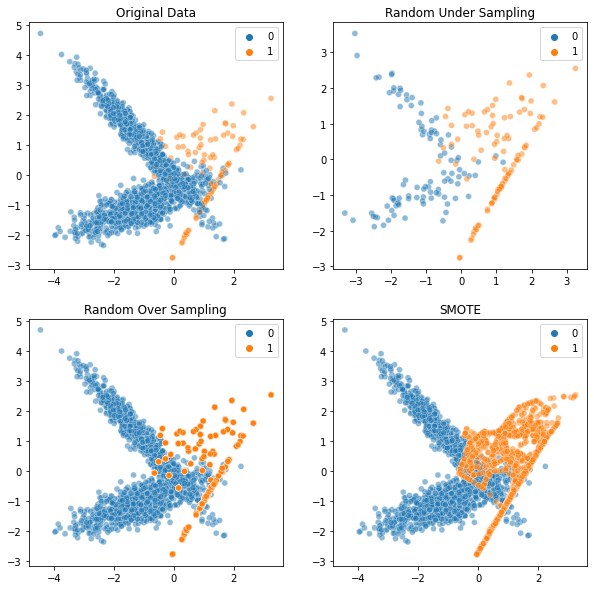

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sns.scatterplot(x[:, 1], x[:, 2], hue=y, ax=axes[0][0], alpha=0.5)
sns.scatterplot(x_under[:, 1], x_under[:,2], hue=y_under, ax=axes[0][1], alpha=0.5)
sns.scatterplot(x_over[:, 1], x_over[:, 2], hue=y_over, ax=axes[1][0], alpha=0.5)
sns.scatterplot(x_sm[:, 1], x_sm[:, 2], hue=y_sm, ax=axes[1][1], alpha=0.5)

axes[0][0].set_title('Original Data')
axes[0][1].set_title('Random Under Sampling')
axes[1][0].set_title('Random Over Sampling')
axes[1][1].set_title('SMOTE')

plt.show()

좌상단의 원본 데이터에서는 0과 1의 갯수가 크게 차이나는 것을 확인. 우상단에서 0의 수 줄어듬,<br>
좌하단에서 1의 갯수 증가 (중복으로 인한 진한 주황), 우하단, 인근에 다른 1번 레이블을 생성함